####***1a.<br>Copy and study the starter code (until “ConvNet as fixed feature extractor”) given by Sasank (CTO of Qure.ai, pytorch contributor, and alumnus of IITB) for classifying ants vs. bees: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. The key feature of this code is that it does not train a model from scratch, but uses transfer learning of a ResNet-18 architecture that is pre-trained on a large dataset (ImageNet) and then only fine-tunes it for the problem at hand.***

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # mounting gdrive with colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing libraries
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

####***1b.<br>Modify the code to run on co-lab without any new features.***

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


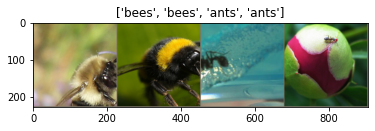

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

####***1c.<br>Modify the code to plot validation loss and accuracy after every training epoch.***

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss=[]
    val_loss=[]
    train_acc=[]
    val_acc=[]
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            curr_lr = optimizer.param_groups[0]['lr']

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR:{curr_lr:.4f}')

            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
            if phase == 'val':
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)


    fig = plt.figure(figsize=(10,10))
    
    # plotting losses vs epochs
    plt.subplot(121)
    plt.plot(train_loss,'-o')
    plt.plot(val_loss,'-o')
    plt.title("Train vs Val losses",fontsize="16")
    plt.xlabel("Epochs",fontsize="14")
    plt.ylabel("Loss",fontsize="14")
    plt.legend(['Train Loss','Val Loss'])
    
    #plotting accuracy vs epochs
    plt.subplot(122)
    plt.plot(train_acc,'-o')
    plt.plot(val_acc,'-o')
    plt.title("Train vs Val accuracy",fontsize="16")
    plt.xlabel("Epochs",fontsize="14")
    plt.ylabel("Accuracy",fontsize="14")
    plt.legend(['Train Accuracy','Val Accuracy'])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

##### ***Test 1 with parameters***

- Learning rate = 0.001
- Momentum = 0.9
- Num of epochs = 25

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6416 Acc: 0.7008 LR:0.0010
val Loss: 0.2373 Acc: 0.9085 LR:0.0010

Epoch 1/24
----------
train Loss: 0.6745 Acc: 0.7377 LR:0.0010
val Loss: 0.3779 Acc: 0.8366 LR:0.0010

Epoch 2/24
----------
train Loss: 0.4475 Acc: 0.8074 LR:0.0010
val Loss: 0.2014 Acc: 0.9216 LR:0.0010

Epoch 3/24
----------
train Loss: 0.4920 Acc: 0.8033 LR:0.0010
val Loss: 0.2625 Acc: 0.8758 LR:0.0010

Epoch 4/24
----------
train Loss: 0.5468 Acc: 0.7910 LR:0.0010
val Loss: 0.4127 Acc: 0.8889 LR:0.0010

Epoch 5/24
----------
train Loss: 0.3839 Acc: 0.8402 LR:0.0010
val Loss: 0.3159 Acc: 0.8954 LR:0.0010

Epoch 6/24
----------
train Loss: 0.5093 Acc: 0.8115 LR:0.0001
val Loss: 0.3686 Acc: 0.8693 LR:0.0001

Epoch 7/24
----------
train Loss: 0.4442 Acc: 0.7869 LR:0.0001
val Loss: 0.2783 Acc: 0.9020 LR:0.0001

Epoch 8/24
----------
train Loss: 0.3118 Acc: 0.8525 LR:0.0001
val Loss: 0.2550 Acc: 0.9150 LR:0.0001

Epoch 9/24
----------
train Loss: 0.3327 Acc: 0.8443 LR:0.0001
val Loss: 0.2321 Acc: 0.9085 LR:

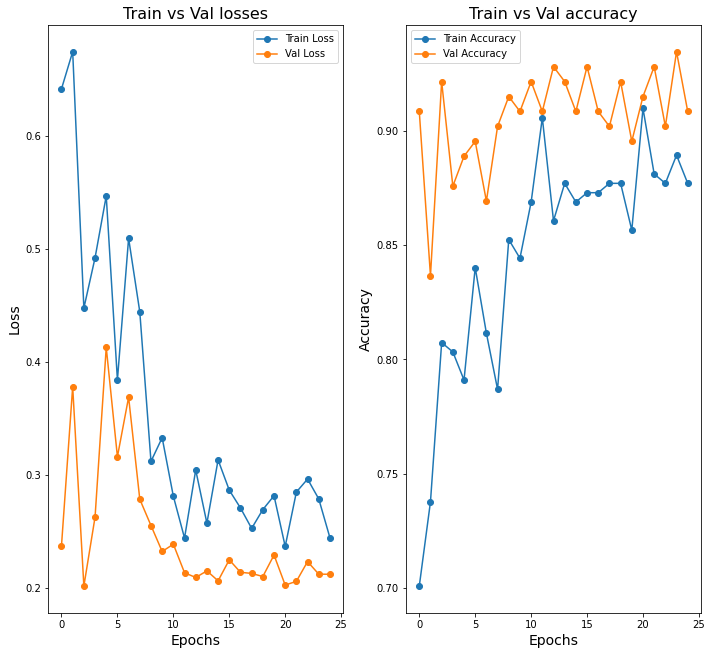

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7850 Acc: 0.5861 LR:0.0010
val Loss: 0.2470 Acc: 0.9346 LR:0.0010

Epoch 1/24
----------
train Loss: 0.5161 Acc: 0.7623 LR:0.0010
val Loss: 0.2036 Acc: 0.9412 LR:0.0010

Epoch 2/24
----------
train Loss: 0.4740 Acc: 0.7828 LR:0.0010
val Loss: 0.6358 Acc: 0.7582 LR:0.0010

Epoch 3/24
----------
train Loss: 0.6133 Acc: 0.7541 LR:0.0010
val Loss: 0.1924 Acc: 0.9477 LR:0.0010

Epoch 4/24
----------
train Loss: 0.3059 Acc: 0.8730 LR:0.0010
val Loss: 0.1988 Acc: 0.9346 LR:0.0010

Epoch 5/24
----------
train Loss: 0.6187 Acc: 0.7705 LR:0.0010
val Loss: 0.3204 Acc: 0.8693 LR:0.0010

Epoch 6/24
----------
train Loss: 0.6258 Acc: 0.7828 LR:0.0001
val Loss: 0.1696 Acc: 0.9477 LR:0.0001

Epoch 7/24
----------
train Loss: 0.3549 Acc: 0.8402 LR:0.0001
val Loss: 0.1989 Acc: 0.9346 LR:0.0001

Epoch 8/24
----------
train Loss: 0.3923 Acc: 0.8115 LR:0.0001
val Loss: 0.1784 Acc: 0.9477 LR:0.0001

Epoch 9/24
----------
train Loss: 0.3019 Acc: 0.8770 LR:0.0001
val Loss: 0.1814 Acc: 0.9412 LR:

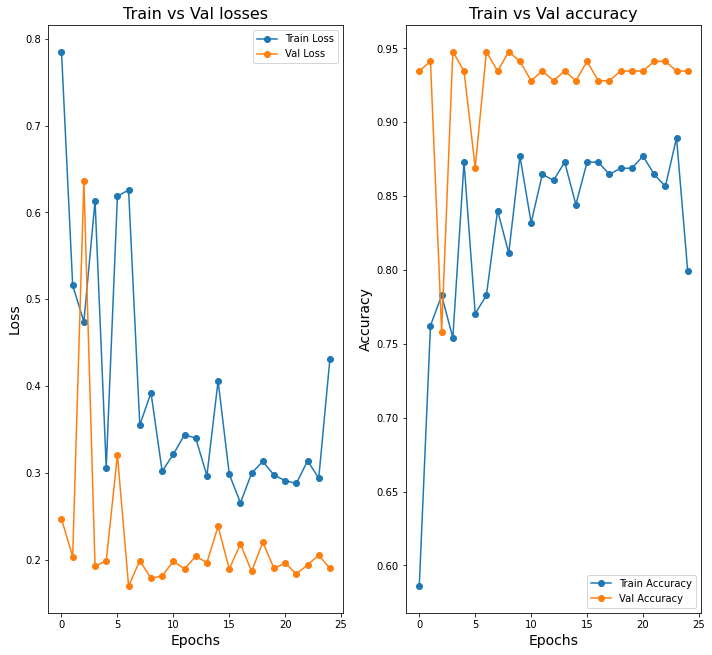

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

####***1d.<br>Change the learning rate, momentum, and number of epochs at least three times to see the net effect on final validation loss and accuracy and its speed of convergence.***

 https://pytorch.org/docs/stable/optim.html

##### ***Test 2 with parameters***

- Learning rate = 0.01
- Momentum = 0.9
- Num of epochs = 15

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 5.8005 Acc: 0.5492 LR:0.0100
val Loss: 2526.5084 Acc: 0.4444 LR:0.0100

Epoch 1/14
----------
train Loss: 3.1798 Acc: 0.5000 LR:0.0100
val Loss: 1.1018 Acc: 0.4575 LR:0.0100

Epoch 2/14
----------
train Loss: 2.3163 Acc: 0.5000 LR:0.0100
val Loss: 1.5438 Acc: 0.5490 LR:0.0100

Epoch 3/14
----------
train Loss: 2.2251 Acc: 0.4754 LR:0.0100
val Loss: 3.0094 Acc: 0.4575 LR:0.0100

Epoch 4/14
----------
train Loss: 1.4976 Acc: 0.4262 LR:0.0100
val Loss: 2.7327 Acc: 0.4575 LR:0.0100

Epoch 5/14
----------
train Loss: 1.2750 Acc: 0.5738 LR:0.0100
val Loss: 1.7502 Acc: 0.5033 LR:0.0100

Epoch 6/14
----------
train Loss: 1.3045 Acc: 0.5451 LR:0.0010
val Loss: 39.2864 Acc: 0.4575 LR:0.0010

Epoch 7/14
----------
train Loss: 0.8604 Acc: 0.5369 LR:0.0010
val Loss: 0.7504 Acc: 0.5425 LR:0.0010

Epoch 8/14
----------
train Loss: 0.7272 Acc: 0.4549 LR:0.0010
val Loss: 0.8142 Acc: 0.5098 LR:0.0010

Epoch 9/14
----------
train Loss: 0.7050 Acc: 0.5123 LR:0.0010
val Loss: 0.8671 Acc: 0.5098

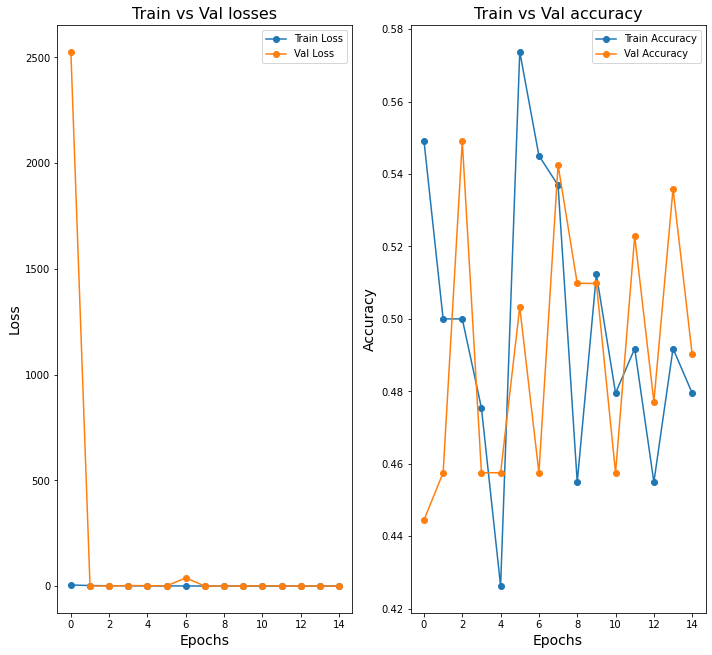

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 3.1088 Acc: 0.6598 LR:0.0100
val Loss: 1.2767 Acc: 0.8627 LR:0.0100

Epoch 1/14
----------
train Loss: 1.2782 Acc: 0.8197 LR:0.0100
val Loss: 0.7474 Acc: 0.9346 LR:0.0100

Epoch 2/14
----------
train Loss: 1.5145 Acc: 0.7992 LR:0.0100
val Loss: 0.5908 Acc: 0.9150 LR:0.0100

Epoch 3/14
----------
train Loss: 1.5923 Acc: 0.8156 LR:0.0100
val Loss: 0.7360 Acc: 0.9150 LR:0.0100

Epoch 4/14
----------
train Loss: 2.4061 Acc: 0.7459 LR:0.0100
val Loss: 5.6763 Acc: 0.6275 LR:0.0100

Epoch 5/14
----------
train Loss: 2.7372 Acc: 0.7500 LR:0.0100
val Loss: 1.8774 Acc: 0.8562 LR:0.0100

Epoch 6/14
----------
train Loss: 3.0218 Acc: 0.7582 LR:0.0010
val Loss: 0.9283 Acc: 0.9412 LR:0.0010

Epoch 7/14
----------
train Loss: 1.1287 Acc: 0.8402 LR:0.0010
val Loss: 0.9293 Acc: 0.9412 LR:0.0010

Epoch 8/14
----------
train Loss: 1.7837 Acc: 0.8279 LR:0.0010
val Loss: 0.8035 Acc: 0.9346 LR:0.0010

Epoch 9/14
----------
train Loss: 1.2944 Acc: 0.8607 LR:0.0010
val Loss: 0.8023 Acc: 0.9412 LR:

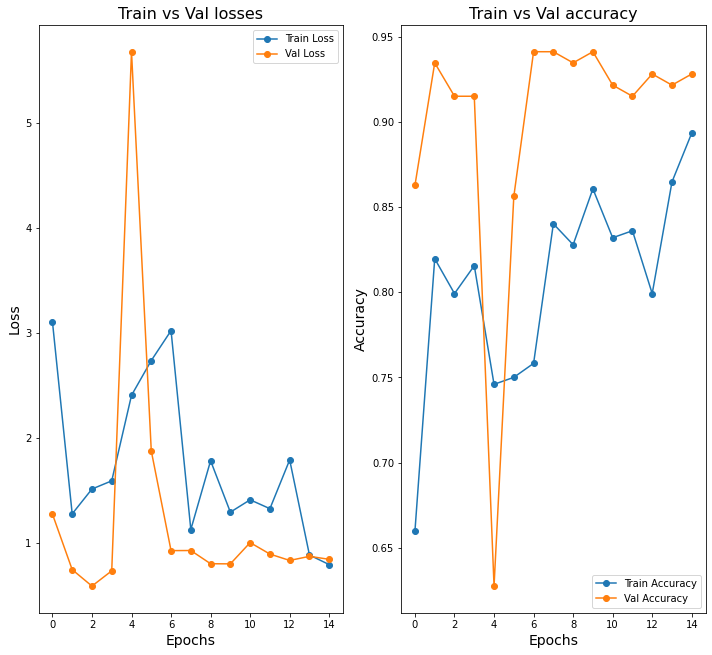

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

##### ***Test 3 with parameters***

- Learning rate = 0.0001
- Momentum = 0.9
- Num of epochs = 35

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/34
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6502 Acc: 0.6311 LR:0.0001
val Loss: 0.4451 Acc: 0.8170 LR:0.0001

Epoch 1/34
----------
train Loss: 0.5099 Acc: 0.7459 LR:0.0001
val Loss: 0.3294 Acc: 0.8889 LR:0.0001

Epoch 2/34
----------
train Loss: 0.4461 Acc: 0.7869 LR:0.0001
val Loss: 0.2849 Acc: 0.9020 LR:0.0001

Epoch 3/34
----------
train Loss: 0.3640 Acc: 0.8484 LR:0.0001
val Loss: 0.2507 Acc: 0.9216 LR:0.0001

Epoch 4/34
----------
train Loss: 0.3678 Acc: 0.8484 LR:0.0001
val Loss: 0.2274 Acc: 0.9150 LR:0.0001

Epoch 5/34
----------
train Loss: 0.3883 Acc: 0.8525 LR:0.0001
val Loss: 0.2047 Acc: 0.9477 LR:0.0001

Epoch 6/34
----------
train Loss: 0.3977 Acc: 0.8197 LR:0.0000
val Loss: 0.2221 Acc: 0.9216 LR:0.0000

Epoch 7/34
----------
train Loss: 0.3471 Acc: 0.8402 LR:0.0000
val Loss: 0.1961 Acc: 0.9477 LR:0.0000

Epoch 8/34
----------
train Loss: 0.3372 Acc: 0.8730 LR:0.0000
val Loss: 0.2011 Acc: 0.9346 LR:0.0000

Epoch 9/34
----------
train Loss: 0.3107 Acc: 0.8770 LR:0.0000
val Loss: 0.2021 Acc: 0.9346 LR:

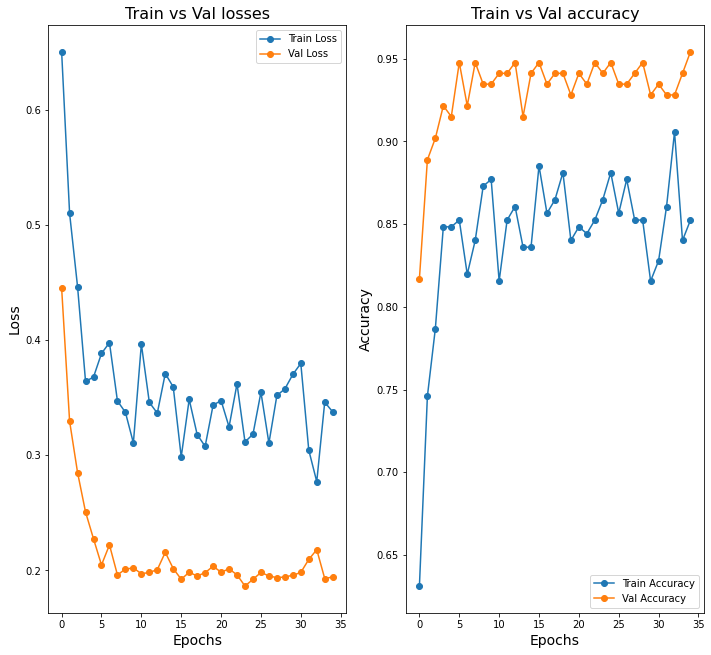

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=35)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/34
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7116 Acc: 0.5533 LR:0.0001
val Loss: 0.5723 Acc: 0.7255 LR:0.0001

Epoch 1/34
----------
train Loss: 0.5778 Acc: 0.6926 LR:0.0001
val Loss: 0.4864 Acc: 0.8235 LR:0.0001

Epoch 2/34
----------
train Loss: 0.5426 Acc: 0.7459 LR:0.0001
val Loss: 0.3954 Acc: 0.8889 LR:0.0001

Epoch 3/34
----------
train Loss: 0.4695 Acc: 0.8033 LR:0.0001
val Loss: 0.3591 Acc: 0.8889 LR:0.0001

Epoch 4/34
----------
train Loss: 0.4482 Acc: 0.7992 LR:0.0001
val Loss: 0.3350 Acc: 0.8824 LR:0.0001

Epoch 5/34
----------
train Loss: 0.4457 Acc: 0.8115 LR:0.0001
val Loss: 0.2983 Acc: 0.9085 LR:0.0001

Epoch 6/34
----------
train Loss: 0.4354 Acc: 0.8074 LR:0.0000
val Loss: 0.3350 Acc: 0.8693 LR:0.0000

Epoch 7/34
----------
train Loss: 0.4367 Acc: 0.8074 LR:0.0000
val Loss: 0.2821 Acc: 0.9150 LR:0.0000

Epoch 8/34
----------
train Loss: 0.4257 Acc: 0.7992 LR:0.0000
val Loss: 0.3041 Acc: 0.9085 LR:0.0000

Epoch 9/34
----------
train Loss: 0.4766 Acc: 0.7623 LR:0.0000
val Loss: 0.2678 Acc: 0.9412 LR:

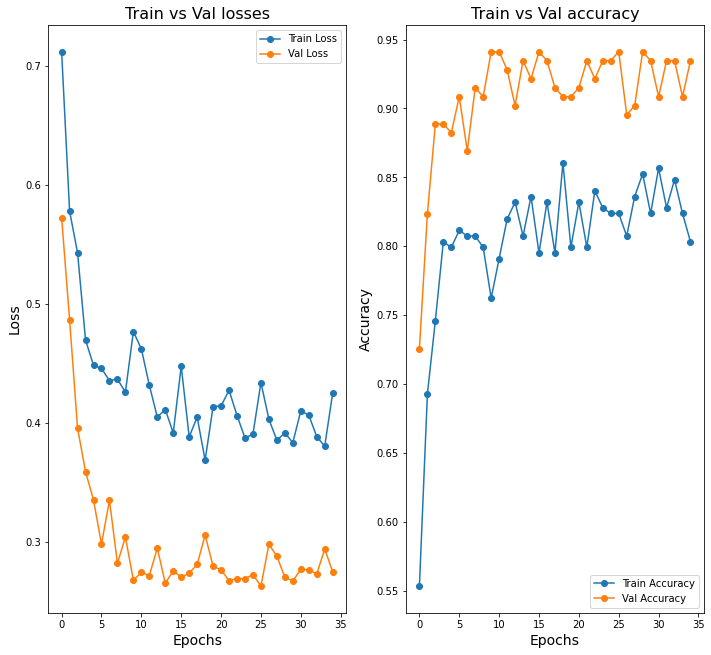

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=35)

####***1e.<br>Introduce weight decay (L2 penalty on weights) and find a good value for the weight decay factor.***

##### ***Weight Decay = 1e-5***

We are taking the TEST 1 model and adding a weight decay of 1e-05 to see the effect.

So the parameters are:
- Learning rate = 0.001
- Momentum = 0.9
- Num of epochs = 25
- Weight decay = 1e-05

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-05)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8200 Acc: 0.6270 LR:0.0010
val Loss: 0.1981 Acc: 0.9216 LR:0.0010

Epoch 1/24
----------
train Loss: 0.5620 Acc: 0.8033 LR:0.0010
val Loss: 0.3344 Acc: 0.8693 LR:0.0010

Epoch 2/24
----------
train Loss: 0.5329 Acc: 0.8197 LR:0.0010
val Loss: 0.6342 Acc: 0.7843 LR:0.0010

Epoch 3/24
----------
train Loss: 0.6171 Acc: 0.7623 LR:0.0010
val Loss: 0.9716 Acc: 0.7255 LR:0.0010

Epoch 4/24
----------
train Loss: 0.6430 Acc: 0.7582 LR:0.0010
val Loss: 0.5008 Acc: 0.7843 LR:0.0010

Epoch 5/24
----------
train Loss: 0.8034 Acc: 0.6803 LR:0.0010
val Loss: 0.2417 Acc: 0.9085 LR:0.0010

Epoch 6/24
----------
train Loss: 0.3944 Acc: 0.8279 LR:0.0001
val Loss: 0.2439 Acc: 0.8824 LR:0.0001

Epoch 7/24
----------
train Loss: 0.2544 Acc: 0.9139 LR:0.0001
val Loss: 0.2293 Acc: 0.8954 LR:0.0001

Epoch 8/24
----------
train Loss: 0.2651 Acc: 0.8893 LR:0.0001
val Loss: 0.2322 Acc: 0.8954 LR:0.0001

Epoch 9/24
----------
train Loss: 0.3016 Acc: 0.8770 LR:0.0001
val Loss: 0.2061 Acc: 0.9150 LR:

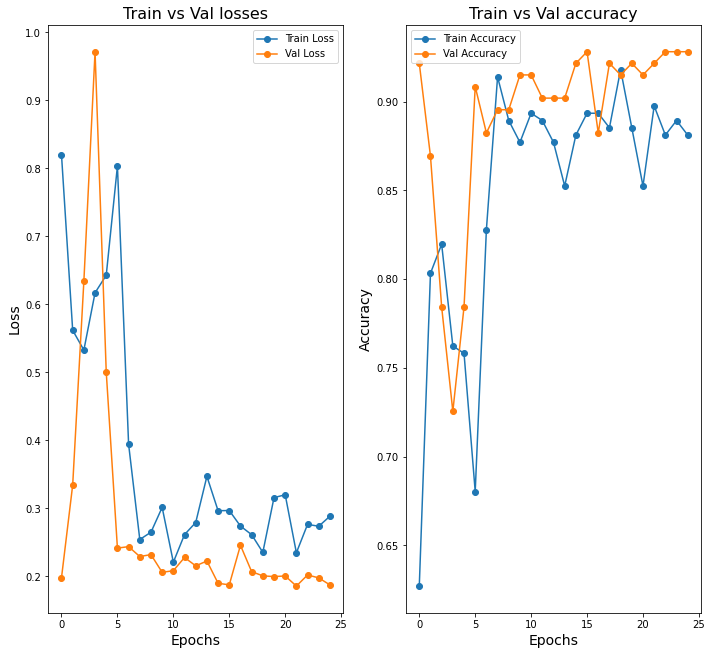

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-05)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8635 Acc: 0.6066 LR:0.0010
val Loss: 0.2253 Acc: 0.9085 LR:0.0010

Epoch 1/24
----------
train Loss: 0.4823 Acc: 0.7787 LR:0.0010
val Loss: 0.2274 Acc: 0.9216 LR:0.0010

Epoch 2/24
----------
train Loss: 0.4557 Acc: 0.8074 LR:0.0010
val Loss: 0.2151 Acc: 0.9150 LR:0.0010

Epoch 3/24
----------
train Loss: 0.7822 Acc: 0.7049 LR:0.0010
val Loss: 0.1668 Acc: 0.9608 LR:0.0010

Epoch 4/24
----------
train Loss: 0.3584 Acc: 0.8402 LR:0.0010
val Loss: 0.1815 Acc: 0.9542 LR:0.0010

Epoch 5/24
----------
train Loss: 0.5030 Acc: 0.8074 LR:0.0010
val Loss: 0.1735 Acc: 0.9477 LR:0.0010

Epoch 6/24
----------
train Loss: 0.6088 Acc: 0.7746 LR:0.0001
val Loss: 0.1852 Acc: 0.9346 LR:0.0001

Epoch 7/24
----------
train Loss: 0.3563 Acc: 0.8648 LR:0.0001
val Loss: 0.1814 Acc: 0.9477 LR:0.0001

Epoch 8/24
----------
train Loss: 0.3004 Acc: 0.8689 LR:0.0001
val Loss: 0.1693 Acc: 0.9412 LR:0.0001

Epoch 9/24
----------
train Loss: 0.4297 Acc: 0.8361 LR:0.0001
val Loss: 0.1750 Acc: 0.9477 LR:

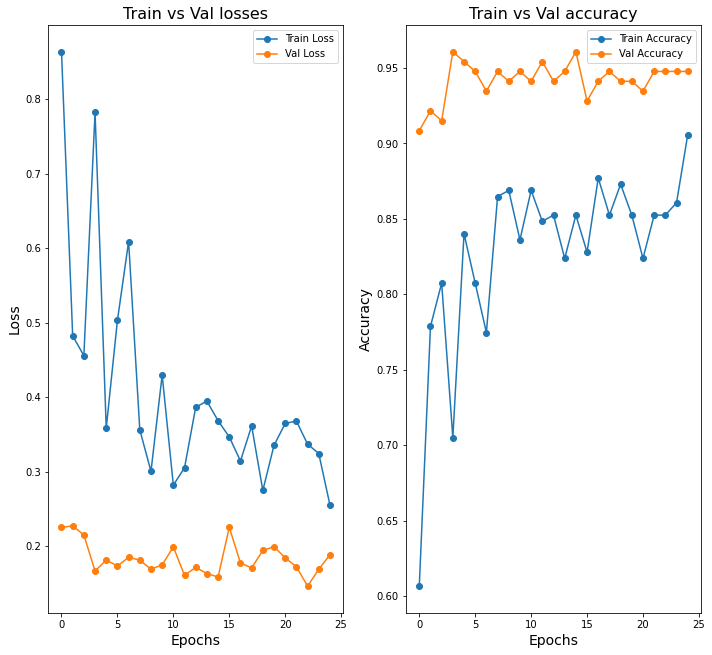

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

##### ***Weight Decay = 1e-4***

Similarly, we are taking the TEST 1 model and adding a weight decay of 1e-04 to see the effect.

So the parameters are:
- Learning rate = 0.001
- Momentum = 0.9
- Num of epochs = 25
- Weight decay = 1e-04

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
\
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-04)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6795 Acc: 0.6475 LR:0.0010
val Loss: 0.2861 Acc: 0.8693 LR:0.0010

Epoch 1/24
----------
train Loss: 0.4411 Acc: 0.8115 LR:0.0010
val Loss: 0.2518 Acc: 0.9020 LR:0.0010

Epoch 2/24
----------
train Loss: 0.7089 Acc: 0.7213 LR:0.0010
val Loss: 0.3547 Acc: 0.8954 LR:0.0010

Epoch 3/24
----------
train Loss: 0.4914 Acc: 0.7787 LR:0.0010
val Loss: 0.2886 Acc: 0.8824 LR:0.0010

Epoch 4/24
----------
train Loss: 0.3818 Acc: 0.8402 LR:0.0010
val Loss: 0.3405 Acc: 0.8954 LR:0.0010

Epoch 5/24
----------
train Loss: 0.5977 Acc: 0.7951 LR:0.0010
val Loss: 0.5097 Acc: 0.8366 LR:0.0010

Epoch 6/24
----------
train Loss: 0.5045 Acc: 0.8115 LR:0.0001
val Loss: 0.3857 Acc: 0.8758 LR:0.0001

Epoch 7/24
----------
train Loss: 0.3580 Acc: 0.8238 LR:0.0001
val Loss: 0.3564 Acc: 0.8758 LR:0.0001

Epoch 8/24
----------
train Loss: 0.4180 Acc: 0.8197 LR:0.0001
val Loss: 0.3348 Acc: 0.8824 LR:0.0001

Epoch 9/24
----------
train Loss: 0.4387 Acc: 0.8238 LR:0.0001
val Loss: 0.2962 Acc: 0.9020 LR:

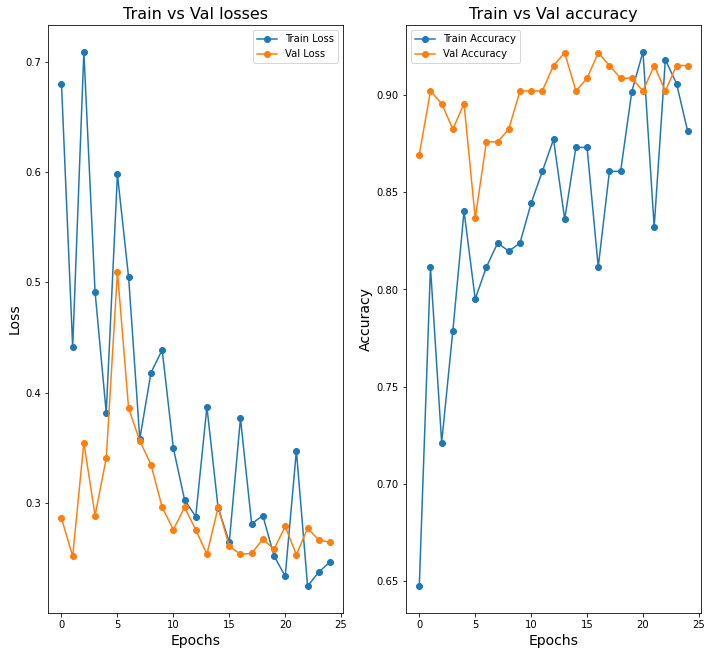

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-04)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5903 Acc: 0.6803 LR:0.0010
val Loss: 0.2953 Acc: 0.8562 LR:0.0010

Epoch 1/24
----------
train Loss: 0.4822 Acc: 0.7869 LR:0.0010
val Loss: 0.1838 Acc: 0.9608 LR:0.0010

Epoch 2/24
----------
train Loss: 0.5163 Acc: 0.8033 LR:0.0010
val Loss: 0.2776 Acc: 0.8889 LR:0.0010

Epoch 3/24
----------
train Loss: 0.4726 Acc: 0.7992 LR:0.0010
val Loss: 0.3853 Acc: 0.8497 LR:0.0010

Epoch 4/24
----------
train Loss: 0.3508 Acc: 0.8443 LR:0.0010
val Loss: 0.2226 Acc: 0.9346 LR:0.0010

Epoch 5/24
----------
train Loss: 0.4972 Acc: 0.7910 LR:0.0010
val Loss: 0.1823 Acc: 0.9412 LR:0.0010

Epoch 6/24
----------
train Loss: 0.4597 Acc: 0.8197 LR:0.0001
val Loss: 0.2784 Acc: 0.9020 LR:0.0001

Epoch 7/24
----------
train Loss: 0.4218 Acc: 0.8320 LR:0.0001
val Loss: 0.2078 Acc: 0.9216 LR:0.0001

Epoch 8/24
----------
train Loss: 0.3720 Acc: 0.7992 LR:0.0001
val Loss: 0.2408 Acc: 0.9020 LR:0.0001

Epoch 9/24
----------
train Loss: 0.3578 Acc: 0.8566 LR:0.0001
val Loss: 0.2008 Acc: 0.9346 LR:

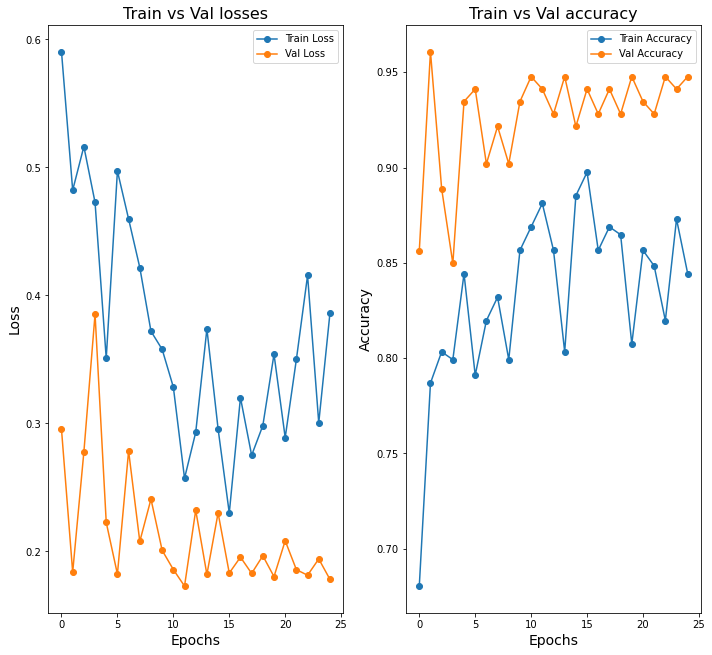

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Clearly we can see that $94\%$ accuracy was acheived in TEST 1 model and adding weight decay produced $96\%$ accuracy which is quite better.